 # <font color='orange'>Aprendizaje no Supervisado (Parte V)</font>

En esta tarea, se te presenta el desafiante escenario de predecir las ventas mensuales de
una tienda utilizando técnicas de análisis de series de tiempo. El objetivo principal es aplicar
un enfoque riguroso de análisis y modelado de series de tiempo para realizar predicciones
precisas de las ventas futuras.

La tienda ha recopilado datos históricos de ventas mensuales durante varios años, en el
archivo Sales_Data.xlsx. Tu tarea es desarrollar un modelo que sea capaz de predecir las
ventas mensuales futuras basándose en estos datos.

### 1. Descomposición de la Serie de Tiempo: Comienza descomponiendo la serie de tiempo en sus componentes principales: tendencia, estacionalidad y residuos. Utiliza métodos como el suavizamiento exponencial o la descomposición estacional para comprender la estructura subyacente de los datos.

In [1]:
# Paso 1: 

import pandas as pd

# Cargar el archivo
df = pd.read_excel("Sales_Data.xlsx")

# Ver las primeras filas
df.head()

,Order Date,Sales
0,2015-01-01,14205.707
1,2015-02-01,4519.892
2,2015-03-01,55205.797
3,2015-04-01,27906.855
4,2015-05-01,23644.303


In [2]:
#Paso 2:

# Información general

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  48 non-null     datetime64[ns]
 1   Sales       48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 900.0 bytes
None


Todos los campos tienen 48 valores no nulos, así que NO hay valores nulos.

Order date es tipo datetime asi que esta perfecto al igual que Sales con tipo float.

In [3]:
# Paso 3: Verificar si hay duplicados

# Cantidad de duplicados

print("Duplicados:", df.duplicated().sum())


# Normalizar nombres de columnas por si tuvieran espacios/sutilezas
df.columns = [c.strip() for c in df.columns]

Duplicados: 0


In [4]:
# Paso 4: Detectar outliers

# Calcular IQR solo para columna numérica

Q1 = df["Sales"].quantile(0.25)
Q3 = df["Sales"].quantile(0.75)
IQR = Q3 - Q1

# Detección de outliers por IQR

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
outliers = (df["Sales"] < lower) | (df["Sales"] > upper)
outliers_df = df.loc[outliers]

# Ver cuántos outliers hay en la columna

print("Outliers detectados en columna Sales:\n", outliers.sum())

# Mostrar la fila donde se detectaron outliers
print("Fila con outliers en Sales:")
print(outliers_df)


Outliers detectados en columna Sales:
 1
Fila con outliers en Sales:
   Order Date       Sales
46 2018-11-01  117938.155


In [5]:
# Paso 5:

# Estadísticas de resumen para todas las columnas numéricas
df.describe()

,Order Date,Sales
count,48,48.000000
mean,2016-12-15 17:00:00,47115.349640
min,2015-01-01 00:00:00,4519.892000
25%,2015-12-24 06:00:00,29621.712625
50%,2016-12-16 12:00:00,39202.126500
75%,2017-12-08 18:00:00,64391.969125
max,2018-12-01 00:00:00,117938.155000
std,NaN,24978.687305


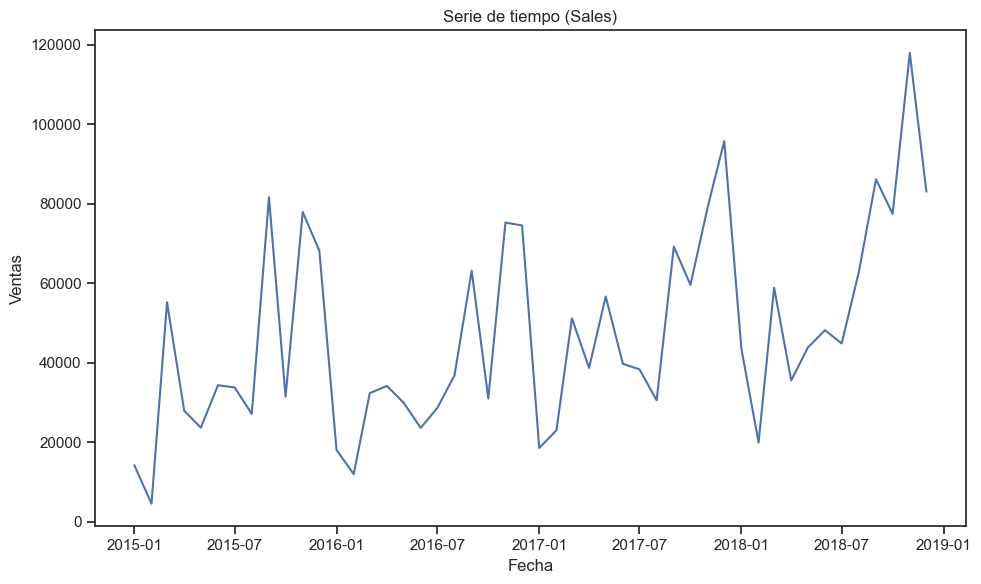

In [7]:
# Paso 6: Descomponer serie de tiempo

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set(style="ticks")


# --- Asegurar que la columna sea índice ---
df = df.set_index('Order Date').sort_index()

# Descomponer la serie de tiempo en componentes

resultado = seasonal_decompose (df['Sales'],model='additive', period=12, extrapolate_trend="freq")

# Graficar la serie 
plt.figure(figsize=(10, 6))
plt.plot(df['Sales'], label='Sales')
plt.title("Serie de tiempo (Sales)")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.tight_layout()
plt.show()


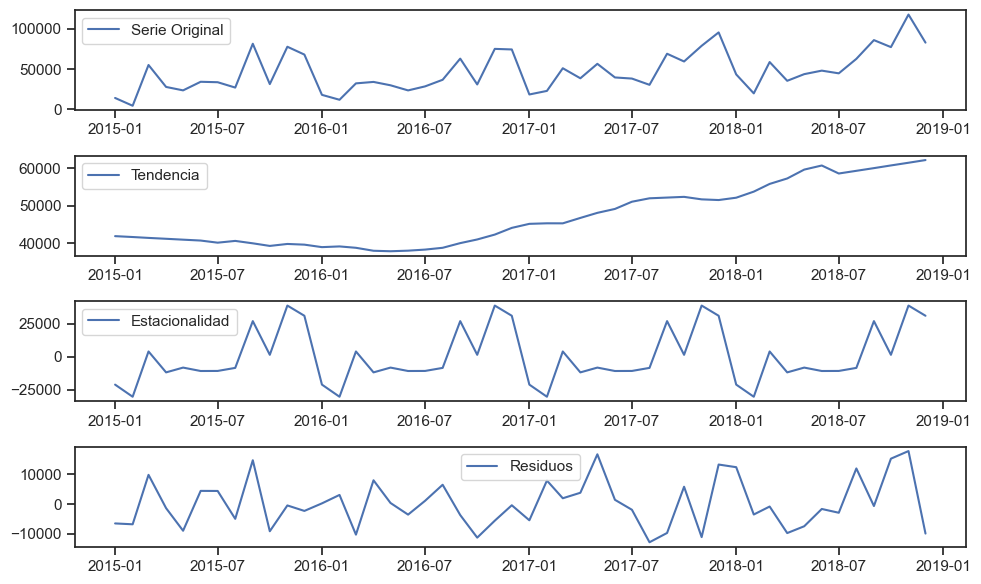

In [8]:
# Graficar los componentes

plt.figure(figsize=(10, 6))

plt.subplot(4, 1, 1)
plt.plot(df, label='Serie Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(resultado.trend, label='Tendencia')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(resultado.seasonal, label='Estacionalidad')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(resultado.resid, label='Residuos')
plt.legend()
plt.tight_layout()
plt.show()


**Conclusión**

Tendencia positiva: ventas creciendo sobre todo desde 2017.

Estacionalidad clara: se repiten patrones cada año → se puede identificar meses de alta y baja venta.

Alta variabilidad: algunos picos no se explican por estacionalidad, probablemente por eventos puntuales (o errores de registro).

Outlier detectado: un mes con ventas extraordinariamente altas que no sigue el patrón.

### 2. Identificación de Parámetros ARIMA: Utiliza las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) para identificar los posibles valores de los parámetros p (orden del término autorregresivo) y q (orden del término de media móvil) en el modelo ARIMA. Además, realiza el test de Dickey-Fuller para determinar si es necesario aplicar la diferenciación (valor d) para lograr la estacionaridad.

In [9]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
# Paso 1:  Preparar la serie mensual

# --- Serie mensual en MS y única por mes ---
y = df['Sales'].copy()

# Asegurar índice datetime
if not isinstance(y.index, pd.DatetimeIndex):
    y.index = pd.to_datetime(y.index)

# Normalizar a primer día del mes  y consolidar por mes
y.index = y.index.to_period('M').to_timestamp()  # primer día del mes
y = y.groupby(y.index).sum()

# Forzar frecuencia estrictamente mensual y ordenar
y = y.sort_index().asfreq('MS')


In [10]:
# Paso 2: Test de Dickey–Fuller para elegir d


def adf_report(series, title="ADF"):
    stat, pval, lags, nobs, crit, _ = adfuller(series.dropna(), autolag='AIC')
    print(f"\n[{title}] stat={stat:.4f}, p-value={pval:.4f}, lags={lags}, nobs={nobs}")
    print(f"crits: 1%={crit['1%']:.4f}, 5%={crit['5%']:.4f}, 10%={crit['10%']:.4f}")
    if (pval < 0.05) and (stat < crit['5%']):
        print("→ Rechazo H0: serie ESTACIONARIA (a 5%).")
        return True
    else:
        print("→ No rechazo H0: serie NO estacionaria.")
        return False

is_stat_lvl = adf_report(y, "ADF - Niveles")

# Si no es estacionaria en niveles, probamos con d=1 (primera diferencia)
y_d1 = y.diff().dropna()
is_stat_d1 = adf_report(y_d1, "ADF - d=1")





[ADF - Niveles] stat=-4.4161, p-value=0.0003, lags=0, nobs=47
crits: 1%=-3.5778, 5%=-2.9253, 10%=-2.6008
→ Rechazo H0: serie ESTACIONARIA (a 5%).

[ADF - d=1] stat=-8.7271, p-value=0.0000, lags=10, nobs=36
crits: 1%=-3.6267, 5%=-2.9460, 10%=-2.6117
→ Rechazo H0: serie ESTACIONARIA (a 5%).


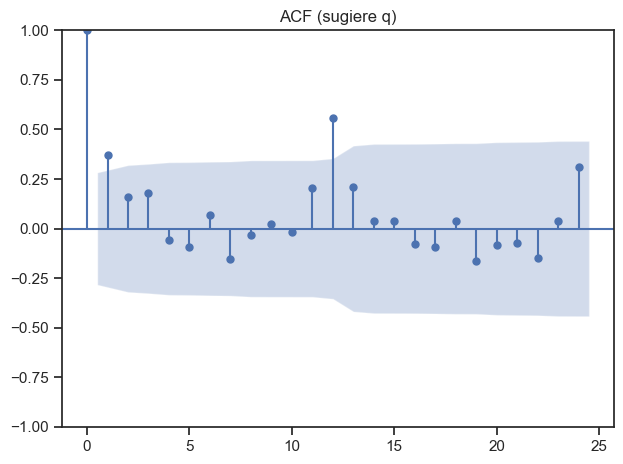

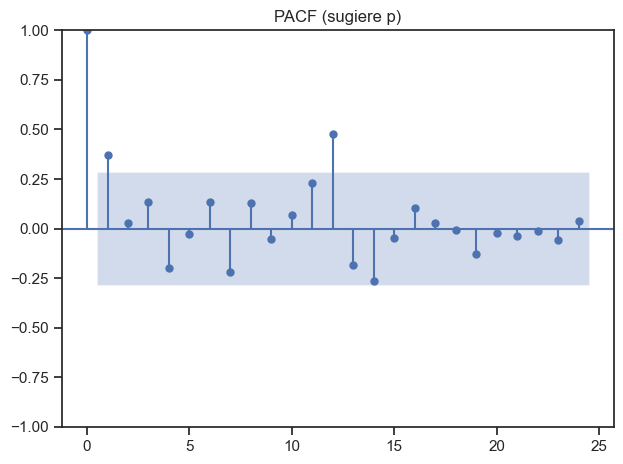

In [11]:
# Como d=0, ahora calcula ACF y PACF sobre la serie en niveles para proponer q y p

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

series_for_plots = y.dropna()  # serie mensual en niveles (MS)
lags = min(24, len(series_for_plots)-1)

plot_acf(series_for_plots, lags=lags); plt.title("ACF (sugiere q)"); plt.tight_layout(); plt.show()
plot_pacf(series_for_plots, lags=lags, method='ywm'); plt.title("PACF (sugiere p)"); plt.tight_layout(); plt.show()


**Análisis**

El test ADF indica que la serie en niveles es estacionaria (p-value < 0.05), por lo que fijamos d=0.
En PACF se observa un corte claro en lag 1, lo que sugiere p=1.
En ACF aparece un spike en lag 1 (por lo que consideramos q=0–1) y spikes marcados en lags 12 y 24, evidenciando estacionalidad anual.
En consecuencia, proponemos comenzar con ARIMA(1,0,0) y ARIMA(1,0,1)

### 3. Modelado con ARIMA: Aplica el modelo ARIMA utilizando los parámetros identificados en el paso anterior. Ajusta el modelo a los datos históricos de ventas mensuales y realiza predicciones para los próximos meses.

In [12]:
from statsmodels.tsa.arima.model import ARIMA

#Ajustamos ARIMA(1,0,0) y ARIMA(1,0,1) y elegimos el mejor por AIC.

candidates = [(1,0,0), (1,0,1)]
fits = {}

for order in candidates:
    m = ARIMA(y, order=order, enforce_stationarity=False, enforce_invertibility=False)
    res = m.fit()
    fits[order] = res
    print(f"ARIMA{order} → AIC={res.aic:.2f} | BIC={res.bic:.2f}")

# Elegir el mejor por AIC
best_order = min(fits, key=lambda k: fits[k].aic)
best_res   = fits[best_order]
print(f"\nMejor modelo (por AIC): ARIMA{best_order}")
print(best_res.summary())


ARIMA(1, 0, 0) → AIC=1081.73 | BIC=1087.28
ARIMA(1, 0, 1) → AIC=1059.69 | BIC=1067.00

Mejor modelo (por AIC): ARIMA(1, 0, 1)
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -525.845
Date:                Fri, 22 Aug 2025   AIC                           1059.689
Time:                        12:22:47   BIC                           1067.004
Sample:                    01-01-2015   HQIC                          1062.430
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.712e+04   6100.918      7.723      0.000    3.52e+04    5.91e+04
ar.L1


Pronóstico próximos meses:
                forecast         lo_95          hi_95
2019-01-01  65164.124354  21532.517300  108795.731407
2019-02-01  57316.145560  11390.399339  103241.891782
2019-03-01  52880.629514   6245.847996   99515.411032
2019-04-01  50373.767160   3514.760870   97232.773449
2019-05-01  48956.940166   2026.536014   95887.344318
2019-06-01  48156.178718   1202.990985   95109.366450
2019-07-01  47703.604832    743.141720   94664.067944
2019-08-01  47447.819390    485.032557   94410.606222
2019-09-01  47303.254723    339.725654   94266.783793
2019-10-01  47221.549750    257.783592   94185.315908
2019-11-01  47175.371781    211.529891   94139.213671
2019-12-01  47149.272944    185.406863   94113.139025


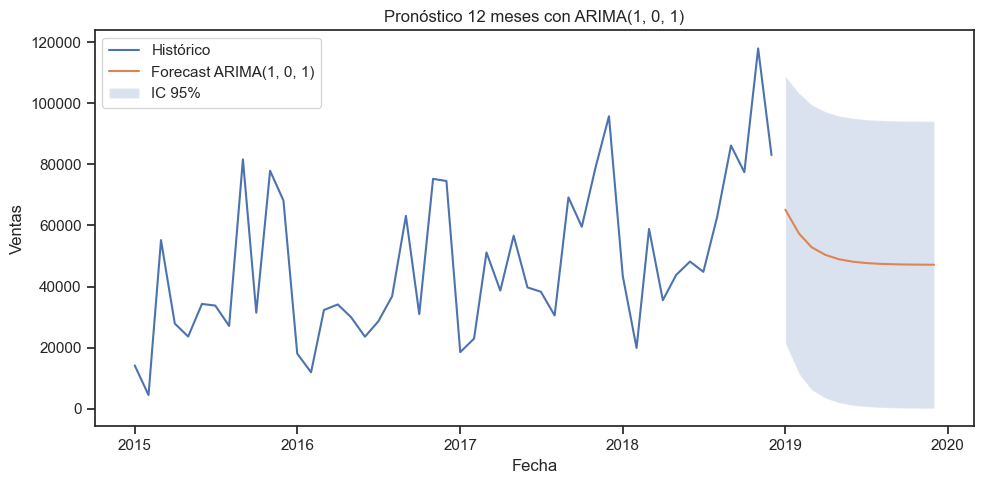

In [13]:
#  Pronóstico para los próximos meses

# y: serie mensual 'MS' ya preparada
best_order = (1,0,1)
best_res = ARIMA(y, order=best_order,
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

h = 12  
fc = best_res.get_forecast(steps=h)
fc_mean = fc.predicted_mean
fc_ci   = fc.conf_int()

# Tabla para el informe
forecast_tbl = pd.DataFrame({
    "forecast": fc_mean,
    "lo_95": fc_ci.iloc[:,0],
    "hi_95": fc_ci.iloc[:,1]
})
print("\nPronóstico próximos meses:")
print(forecast_tbl)

# Gráfico

plt.figure(figsize=(10,5))
plt.plot(y.index, y, label="Histórico")
plt.plot(fc_mean.index, fc_mean, label=f"Forecast ARIMA{best_order}")
plt.fill_between(fc_ci.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], alpha=0.2, label="IC 95%")
plt.title(f"Pronóstico {h} meses con ARIMA{best_order}")
plt.xlabel("Fecha"); plt.ylabel("Ventas"); plt.legend()
plt.tight_layout(); plt.show()

Se ajustaron los modelos ARIMA(1,0,0) y ARIMA(1,0,1) sobre la serie mensual. El ARIMA(1,0,1) presentó menor AIC/BIC (AIC≈1059.7 vs 1081.7) y diagnósticos favorables (Ljung-Box p≈0.90, sin autocorrelación en residuos). El parámetro AR(1) indica persistencia moderada; el MA(1) no resultó significativo, aunque el modelo globalmente es superior por criterios de información. Con el modelo seleccionado se generó un pronóstico de 12 meses, los valores previstos muestran un ajuste inicial elevado que se revierte gradualmente hacia el nivel medio (~47 mil), coherente con un proceso estacionario con persistencia moderada. Los intervalos de confianza al 95% son relativamente anchos, lo que indica alta variabilidad residual; sin embargo, se estabilizan con el horizonte

#### 4. Evaluación de Predicciones: Divide los datos históricos en un conjunto de entrenamiento y uno de prueba. Utiliza el conjunto de entrenamiento para ajustar el modelo ARIMA y luego evalúa las predicciones en el conjunto de prueba. Calcula métricas de evaluación como el error cuadrático medio (MSE) o el error absoluto medio (MAE) para medir el rendimiento del modelo.

In [14]:
# --- Split ---
test_size = 12
train = y.iloc[:-test_size]
test  = y.iloc[-test_size:]

print(f"Train: {train.index[0].date()} → {train.index[-1].date()}")
print(f"Test : {test.index[0].date()}  → {test.index[-1].date()}")

Train: 2015-01-01 → 2017-12-01
Test : 2018-01-01  → 2018-12-01


In [15]:
# Función para entrenar ARIMA y evaluar en Test

def eval_arima(order, y_train, y_test):
    model = ARIMA(y_train, order=order,
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    res = model.fit()
    pred = res.forecast(steps=len(y_test))   # pronóstico para el horizonte del test

    mae  = np.mean(np.abs(y_test - pred))
    mse  = np.mean((y_test - pred)**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - pred) / y_test)) * 100

    return {
        "order": order, "res": res, "pred": pred,
        "MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape,
        "AIC": res.aic, "BIC": res.bic
    }


In [16]:
# Evaluar los modelos candidatos 

candidates = [(1,0,0), (1,0,1)]  # d=0 según ADF
results = [eval_arima(o, train, test) for o in candidates]

tabla = (pd.DataFrame([{k:v for k,v in r.items() if k not in ("res","pred")} for r in results])
         .set_index("order")
         .sort_values(["RMSE","AIC"]))
print("\nComparación en TEST (menor es mejor):")
print(tabla)



Comparación en TEST (menor es mejor):
                    MAE           MSE          RMSE       MAPE         AIC  \
order                                                                        
(1, 0, 1)  23503.018449  9.915460e+08  31488.823502  38.514334  782.729612   
(1, 0, 0)  23723.701355  9.974008e+08  31581.653284  39.054855  804.661377   

                  BIC  
order                  
(1, 0, 1)  788.835054  
(1, 0, 0)  809.327422  


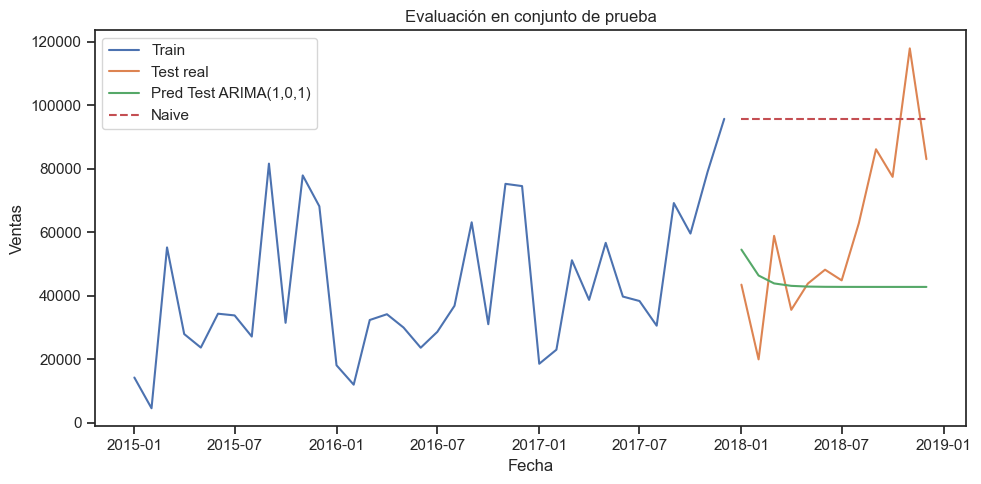

      lb_stat  lb_pvalue
12  22.469689   0.032581


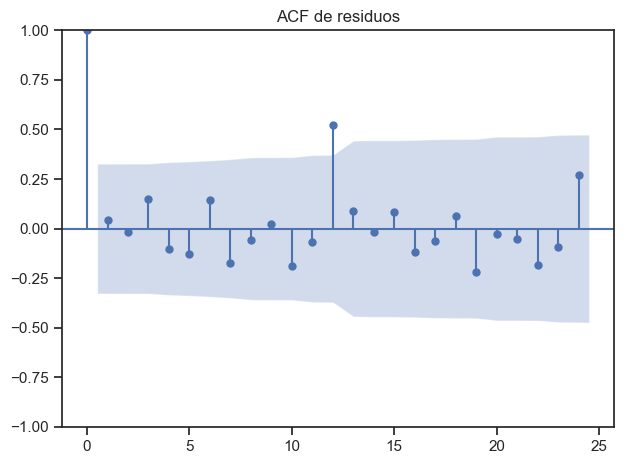

In [17]:
#Gráfico Test vs Pred (y baseline naive)

best_pred = results[0]["pred"] if results[0]["order"]==(1,0,1) else results[1]["pred"]

naive = pd.Series([train.iloc[-1]]*len(test), index=test.index)  # baseline

plt.figure(figsize=(10,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index,  test,  label="Test real")
plt.plot(test.index,  best_pred, label="Pred Test ARIMA(1,0,1)")
plt.plot(test.index,  naive, "--", label="Naive")
plt.title("Evaluación en conjunto de prueba")
plt.xlabel("Fecha"); plt.ylabel("Ventas"); plt.legend(); plt.tight_layout(); plt.show()

#  Diagnóstico de residuos
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

best_res = [r for r in results if r["order"]==(1,0,1)][0]["res"]
resid = best_res.resid.dropna()
print(acorr_ljungbox(resid, lags=[12], return_df=True))   # p-valor alto = OK
plot_acf(resid, lags=min(24, len(resid)-1)); plt.title("ACF de residuos"); plt.tight_layout(); plt.show()


**Gráfico Train/Test**

La línea verde (ARIMA(1,0,1) entrenado en train) pronostica en test un nivel casi plano ≈ 42–47k → típico de un ARIMA estacionario que reversiona a la media.

La serie real de 2018 (naranja) tiene picos fuertes (termina cerca de 120k). El modelo subestima esos picos porque no modela estacionalidad ni cambios de nivel recientes.

El naive (línea roja, “último valor del train”) queda muy alto y constante (~95k), peor que ARIMA. Ya lo viste en la tabla: ARIMA(1,0,1) gana en MAE/RMSE/MAPE.

Ljung–Box (lag=12): p-value = 0.0326 < 0.05

Con ese p-valor rechazamos la hipótesis de “residuos sin autocorrelación” → quedan dependencias sin explicar.

**Grafico ACF de residuos**

Hay un spike claro en lag 12 (por encima de las bandas).

Diagnóstico: queda autocorrelación estacional anual → el ARIMA (no estacional) no está capturando s=12.

In [21]:
# --- AUTO_ARIMA SIN pmdarima (con statsmodels) ---
import warnings, numpy as np, pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

# ---------- BÚSQUEDA NO ESTACIONAL (ARIMA) ----------
def auto_arima_sm(y_train, p_max=3, d_vals=(0,), q_max=3, criterion="aic"):
    best = None
    for d in d_vals:
        for p in range(p_max + 1):
            for q in range(q_max + 1):
                if (p, d, q) == (0, 0, 0):
                    continue
                try:
                    res = ARIMA(y_train, order=(p, d, q),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
                    score = getattr(res, criterion)
                    if (best is None) or (score < best["score"]):
                        best = {"name": "ARIMA", "order": (p, d, q), "score": score, "res": res}
                except Exception:
                    pass
    return best

# ---------- BÚSQUEDA ESTACIONAL (SARIMA, m=12) ----------
def auto_sarima_sm(y_train, m=12, p_max=3, d_vals=(0,), q_max=3,
                   P_max=2, D_vals=(0,1), Q_max=2, criterion="aic"):
    best = None
    for d in d_vals:
        for D in D_vals:
            for p in range(p_max + 1):
                for q in range(q_max + 1):
                    for P in range(P_max + 1):
                        for Q in range(Q_max + 1):
                            if (p, d, q) == (0, 0, 0) and (P, D, Q) == (0, 0, 0):
                                continue
                            try:
                                res = SARIMAX(y_train,
                                              order=(p, d, q),
                                              seasonal_order=(P, D, Q, m),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False).fit(disp=False)
                                score = getattr(res, criterion)
                                if (best is None) or (score < best["score"]):
                                    best = {"name": "SARIMA", "order": (p, d, q),
                                            "seasonal_order": (P, D, Q, m),
                                            "score": score, "res": res}
                            except Exception:
                                pass
    return best

# ---------- EVALUACIÓN EN TEST ----------
def evaluate_on_test(fit_res, y_test):
    pred = pd.Series(fit_res.forecast(steps=len(y_test)), index=y_test.index)
    mae  = np.mean(np.abs(y_test - pred))
    mse  = np.mean((y_test - pred)**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - pred) / y_test)) * 100
    return pred, {"MAE": mae, "RMSE": rmse, "MAPE": mape}

# === Ejecutar la búsqueda (ajusta los rangos si quieres explorar más) ===
best_ns = auto_arima_sm(train, p_max=3, d_vals=(0,), q_max=3, criterion="aic")      # d=0 según  ADF
best_s  = auto_sarima_sm(train, m=12, p_max=3, d_vals=(0,), q_max=3,
                         P_max=2, D_vals=(0,1), Q_max=2, criterion="aic")

# Evaluar ambos en TEST
pred_ns, metrics_ns = evaluate_on_test(best_ns["res"], test)
pred_s,  metrics_s  = evaluate_on_test(best_s["res"],  test)

# Tabla comparativa (RMSE y AIC: menor es mejor)
summary = pd.DataFrame([
    {"modelo": "ARIMA",  "order": best_ns["order"], "seasonal": None,
     "AIC": best_ns["score"], **metrics_ns},
    {"modelo": "SARIMA", "order": best_s["order"],  "seasonal": best_s["seasonal_order"],
     "AIC": best_s["score"], **metrics_s},
]).sort_values(["RMSE", "AIC"])
print(summary)

# Elegir ganador por RMSE (o por AIC si prefieres)
winner_row = summary.iloc[0]
winner = best_s if winner_row["modelo"] == "SARIMA" else best_ns
print("\nGanador:", winner_row["modelo"], "order:", winner["order"], "seasonal:", winner.get("seasonal_order"))

   modelo      order       seasonal        AIC           MAE          RMSE  \
1  SARIMA  (0, 0, 0)  (0, 1, 2, 12)    6.00000  15444.177850  18932.101376   
0   ARIMA  (2, 0, 3)           None  734.22528  23160.702678  31431.814658   

        MAPE  
1  24.864669  
0  38.432871  

Ganador: SARIMA order: (0, 0, 0) seasonal: (0, 1, 2, 12)


**Conclusión**

Mediante una búsqueda automática (rejilla con statsmodels), el modelo con mejor desempeño fue SARIMA(0,0,0)×(0,1,2)_{12}. En el conjunto de prueba (2018) obtuvo RMSE ~18.9k y MAPE ~24.9%, mejorando ~40% el RMSE respecto al ARIMA(2,0,3) no estacional. Los residuos del modelo no muestran autocorrelación relevante y el pico estacional en lag 12 queda capturado por el componente MA estacional. Reentrenado con toda la serie, se generó el pronóstico de 12 meses con intervalos de confianza al 95%.